# Assignment 2 

## Question 1 and 2

In [1]:
from dataclasses import dataclass
from typing import Tuple, Dict
from rl.markov_process import MarkovProcess
from rl.markov_process import FiniteMarkovProcess
from rl.markov_process import Transition
from rl.distribution import SampledDistribution, Categorical, Constant

import itertools
import numpy as np
from matplotlib import pyplot as plt

In [2]:
@dataclass(frozen=True)
class PawnState:
    position: int
        

class SnakesAndLaddersMPFinite(FiniteMarkovProcess[PawnState]):
    
    def __init__(
        self,
        length: int,
        die: int,
        snakes:  Dict[int, int],
        ladders:  Dict[int, int]
        ):
        self.length: int = length
        self.die: int = die
        self.snakes: Dict[int, int] = snakes
        self.ladders: Dict[int, int] = ladders
        
        self.start_state = Constant(PawnState(1))

        super().__init__(self.get_transition_map())
        
    def get_transition_map(self) -> Transition[PawnState]:
        d: Dict[PawnState, Categorical[PawnState]] = {}
        # iterate through all locations except for the last position which is a terminal state
        for start in range(1,self.length):
            s: PawnState = PawnState(start)
            s_prob_map: Mapping[PawnState, float] = {} 
            # iterate through all die faces
            for jump in range(1,self.die+1):
                # assuming that we start at location 1 and that there is no snake or ladder
                # at the starting point
                land: int = min(start + jump, self.length)
                # go through snakes and ladders
                while ((land in self.snakes) or \
                       (land in self.ladders)):
                    if (land in self.snakes):
                        land = self.snakes[land]
                    else:
                        land = self.ladders[land]
                s_prime: PawnState = PawnState(land)
                s_prob_map[s_prime] = s_prob_map[s_prime] + 1/self.die if s_prime in s_prob_map \
                                      else 1/self.die
            d[s] = Categorical(s_prob_map)
        # have the map return non for the terminal state
        d[PawnState(self.length)] = None
        return d
                    
        


def snl_traces(
    snl_mp: SnakesAndLaddersMPFinite,
    num_traces: int
)->np.ndarray:
    return np.hstack([
        len([s for s in snl_mp.simulate(snl_mp.start_state)])-1\
        for _ in range(num_traces)])
     

Sample mean of the number of jumps
----------------------------------
33.541  jumps


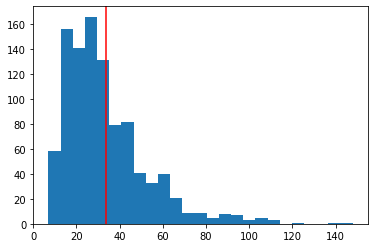

In [3]:
if __name__ == '__main__':
    user_length = 100
    user_die = 6
    user_snakes:  Dict[int, int] = {16:6,47:26,49:11,56:53,64:60,87:24,93:73,95:75,98:78}
    user_ladders:  Dict[int, int] = {1:38,4:14,9:31,21:42,28:84,36:44,51:67,71:91,80:100}
    snl_mp_  = SnakesAndLaddersMPFinite(length  = user_length, 
                                         die     = user_die,
                                         snakes  = user_snakes,
                                         ladders = user_ladders)
    # compute the traces
    traces = snl_traces(
        snl_mp = snl_mp_,
        num_traces = 1000)
    
    # plot
    fig, ax = plt.subplots()
    _ = ax.hist(traces, bins=25)
    ax.axvline(traces.mean(),c="r")
    
    print("Sample mean of the number of jumps")
    print("----------------------------------")
    print(traces.mean(), " jumps")

# Question 3

In [4]:
@dataclass(frozen=True)
class FrogState:
    position: int
        

class FrogPuzzleMPFinite(FiniteMarkovProcess[PawnState]):
    
    def __init__(
        self,
        length: int,
        ):
        self.length: int = length
        self.start_state = Constant(FrogState(0))
        super().__init__(self.get_transition_map())
        
    def get_transition_map(self) -> Transition[FrogState]:
        d: Dict[Frog, Categorical[FrogState]] = {}
        # iterate through all locations except for the last position which is a terminal state
        for start in range(0,self.length):
            s: FrogState = FrogState(start)
            s_prob_map: Mapping[FrogState, float] = {}
            p: float = 1/(self.length-start)
            # iterate through all possible jumps
            for jump in range(1,self.length-start+1):
                # assuming that we start at location 1 and that there is no snake or ladder
                # at the starting point
                s_prime: FrogState = FrogState(start+jump)
                s_prob_map[s_prime] = p
            d[s] = Categorical(s_prob_map)
        # have the map return None for the terminal state
        d[FrogState(self.length)] = None
        return d


def fp_traces(
    fp_mp: FrogPuzzleMPFinite,
    num_traces: int
)->np.ndarray:
    return np.hstack([
        len([s for s in fp_mp.simulate(fp_mp.start_state)])-1\
        for _ in range(num_traces)])
    
        
        
        

Sample mean of the number of jumps
----------------------------------
2.9116  jumps


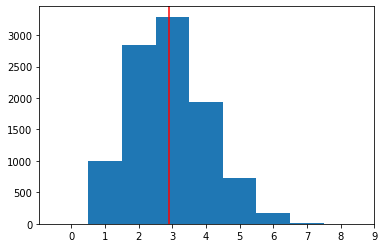

In [5]:
if __name__ == '__main__':
    user_length = 10
    fp_mp_  = FrogPuzzleMPFinite(length = user_length)
    
    traces = fp_traces(
        fp_mp = fp_mp_,
        num_traces = 10000)
    
    bins = np.arange(0, traces.max() + 1.5) - 0.5
    fig, ax = plt.subplots()
    _ = ax.hist(traces, bins)
    ax.axvline(traces.mean(),c="r")
    ax.set_xticks(bins + 0.5)
    
    print("Sample mean of the number of jumps")
    print("----------------------------------")
    print(traces.mean(), " jumps")

# Question 4

In [6]:
# dependencies
from dataclasses import dataclass
from typing import Tuple, Dict
from rl.markov_process import MarkovRewardProcess
from rl.markov_process import FiniteMarkovRewardProcess
from rl.markov_process import RewardTransition
from rl.distribution import SampledDistribution, Categorical
import numpy as np

In [7]:
@dataclass(frozen=True)
class PawnState:
    position: int
        
class  SnakesAndLaddersMRPFinite(FiniteMarkovRewardProcess[PawnState]):
    
    def __init__(
        self,
        length: int,
        die: int,
        snakes:  Dict[int, int],
        ladders:  Dict[int, int]
        ):
        self.length: int = length
        self.die: int = die
        self.snakes: Dict[int, int] = snakes
        self.ladders: Dict[int, int] = ladders
        
        self.start_state = Constant(PawnState(1))

        super().__init__(self.get_transition_reward_map())
        
    def get_transition_reward_map(self) -> RewardTransition[PawnState]:
        d: Dict[PawnState, Categorical[Tuple[PawnState, int]]] = {}
        # iterate through all locations except for the last position which is a terminal state
        for start in range(1,self.length):
            s: PawnState = PawnState(start)
            s_prob_map: Mapping[Tuple[PawnState, int], float] = {} 
            # iterate through all 6 die faces
            for jump in range(1,self.die+1):
                # assuming that we start at location 1 and that there is no snake or ladder
                # at the starting point
                land: int = min(start + jump, self.length)
                # go through snakes and ladders
                while ((land in self.snakes) or \
                       (land in self.ladders)):
                    if (land in self.snakes):
                        land = self.snakes[land]
                    else:
                        land = self.ladders[land]
                s_prime: PawnState = PawnState(land)
                s_prob_map[(s_prime,1)] = s_prob_map[s_prime] + 1/self.die+1 if s_prime in s_prob_map \
                                      else 1/self.die+1
            d[s] = Categorical(s_prob_map)
        # have the map return non for the terminal state
        d[PawnState(self.length)] = None
        return d

Sample mean of the number of jumps
----------------------------------
35.215  jumps

 Expected number of jumps remaining
----------------------------------
{PawnState(position=5): 34.446,
 PawnState(position=2): 34.882,
 PawnState(position=3): 34.34,
 PawnState(position=1): 35.061,
 PawnState(position=32): 30.907,
 PawnState(position=33): 30.689,
 PawnState(position=34): 30.434,
 PawnState(position=37): 30.118,
 PawnState(position=35): 30.24,
 PawnState(position=36): 30.283,
 PawnState(position=38): 29.834,
 PawnState(position=39): 29.38,
 PawnState(position=40): 28.904,
 PawnState(position=42): 28.393,
 PawnState(position=41): 29.071,
 PawnState(position=48): 24.321,
 PawnState(position=49): 22.324,
 PawnState(position=50): 22.157,
 PawnState(position=51): 22.743,
 PawnState(position=53): 22.176,
 PawnState(position=52): 22.386,
 PawnState(position=22): 29.113,
 PawnState(position=23): 29.492,
 PawnState(position=24): 29.743,
 PawnState(position=25): 29.935,
 PawnState(position=26): 3

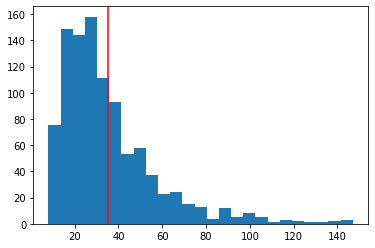

In [8]:
if __name__ == '__main__':
    user_length = 100
    user_die = 6
    user_snakes:  Dict[int, int] = {16:6,47:26,49:11,56:53,64:60,87:24,93:73,95:75,98:78}
    user_ladders:  Dict[int, int] = {1:38,4:14,9:31,21:42,28:84,36:44,51:67,71:91,80:100}
    snl_mrp_  = SnakesAndLaddersMRPFinite(length  = user_length, 
                                          die     = user_die,
                                          snakes  = user_snakes,
                                          ladders = user_ladders)

    # compute the traces
    traces = snl_traces(
        snl_mp = snl_mrp_,
        num_traces = 1000)
    
    # plot
    fig, ax = plt.subplots()
    _ = ax.hist(traces, bins=25)
    ax.axvline(traces.mean(),c="r")
        
    print("Sample mean of the number of jumps")
    print("----------------------------------")
    print(traces.mean(), " jumps")
    
    print("\n","Expected number of jumps remaining")
    print("----------------------------------")
    snl_mrp_.display_value_function(gamma=1)

# Question 5